In [14]:
import nengo
import nengo_loihi
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
import os

nengo_loihi.set_defaults()
np.random.seed(42)
os.environ["SLURM"] = "1"

# Speed for normalization
max_speed = 5
speed = 1

tau_i = 0.1
tau_d = 0.1
Kp = -1
Ki = -0.1
Kd = 0.35


class VehicleModel:
    def __init__(self):
        self.__throttle = 0.0
        self.__brake = 0.0
        self.__speed = 0.0

    # Throttle getter&setter
    def get_throttle(self):
        return self.__throttle

    def set_throttle(self, value):
        self.__throttle = np.clip(value, 0,1)

    # Brake getter&setter
    def get_brake(self):
        return self.__brake

    def set_brake(self, value):
        self.__brake = np.clip(value, 0, 1)

    # Speed getter
    def get_speed(self):
        return self.__speed

    # Speed setter
    def set_speed(self, value):
        self.__speed = value


car = VehicleModel()

def set_throttle_speed(t, x):
            val = x[0]
            if val >= 0:
                car.set_throttle(val)
                car.set_brake(0)
            else:
                car.set_throttle(0)
                car.set_brake(-val)

            s = car.get_speed()
            t = car.get_throttle()
            b = car.get_brake()

            # Use simple speed model
            s -= 0.005 # friction

            if t > 0.2: # throttle big enough to overcome friction
                s += t*0.025
            if b > 0:
                s -= b*0.05 # brakes are stronger than throttle
            s = np.clip(s, 0, 15) # clip max speed

            car.set_speed(s)
            s = s/max_speed

            return x[0],s

def feedback(x):
    return x
    


def PID_Controller():

    model = nengo.Network(seed=5)
    N = 500

    with model:   
        
        model.cur_speed = nengo.Node(size_in=1)
        model.throttle = nengo.Node(size_in=1)
        model.req_speed = nengo.Node(1)
        model.throttle_speed = nengo.Node(set_throttle_speed, size_in=1,size_out=2)
        
        nengo.Connection(model.throttle_speed[0],model.throttle)
        nengo.Connection(model.throttle_speed[1],model.cur_speed)
        
        model.vel_err = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=1.2, label='vel_err')
        model.int_ctrl = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=2, label='int_ctrl')
        model.diff_ctrl = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=2, label='diff_ctrl')
    
        model.err_sum = nengo.Ensemble(n_neurons=int(N*2), dimensions=1, radius=2, label='err_sum')
        
        
        # error = cur_speed - req_speed
        nengo.Connection(model.cur_speed, model.vel_err, transform=1)
        nengo.Connection(model.req_speed, model.vel_err, transform=-1)
                         
        
        # Proportional
        nengo.Connection(model.vel_err, model.err_sum, transform=Kp,
                            label='Kp')
        
        # Integral
        nengo.Connection(model.vel_err, model.int_ctrl, transform=tau_i)
        nengo.Connection(model.int_ctrl, model.int_ctrl, function=feedback, synapse=tau_i)
        nengo.Connection(model.int_ctrl, model.err_sum, transform=Ki)
        
        # Derivative
        nengo.Connection(model.vel_err, model.diff_ctrl, transform=-1, synapse=tau_d)
        nengo.Connection(model.vel_err, model.diff_ctrl, transform=1)
        nengo.Connection(model.diff_ctrl, model.err_sum, transform=Kd)
        
        # Convert to throttle
        nengo.Connection(model.err_sum, model.throttle_speed, synapse=0.01)
        
        
        model.probe_vel_err = nengo.Probe(model.vel_err, synapse=0.05)

        model.probe_req_speed = nengo.Probe(model.req_speed, synapse=0.01)
        model.probe_cur_speed = nengo.Probe(model.cur_speed, synapse=0.01)
        model.probe_throttle = nengo.Probe(model.throttle, synapse=0.05)
    
        return model
   
  
    
model_PID = nengo.Network(label='PID Controller')
with model_PID:
    pid = PID_Controller()
    
    print('n_neurons: {}'.format(pid.n_neurons))



n_neurons: 4000


In [15]:
nengo_loihi.hardware.interface.HostSnip.recv_timeout = 1.0  # Default is 0.01 (10 ms)
nengo_loihi.hardware.interface.HostSnip.recv_retries = 100  # Default is 10

with nengo_loihi.Simulator(model_PID) as sim_loihi_pid:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi_pid.run(6)

/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 4 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:34475
INFO:DRV:      Host server up..............Done 0.35s
INFO:DRV:      Encoding axons/synapses.....Done 1.09s
INFO:DRV:      Compiling Embedded snips....Done 0.42s
INFO:DRV:      Compiling Host snips........Done 1.09s
INFO:DRV:      Encoding probes.............Done 0.84ms
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604665905.5730765/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Transferring probes.........Done 3.45ms
INFO:DRV:      Configuring registers.......Done 0.16s
INFO:DRV:      Transferring spikes.........Done 1.13ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

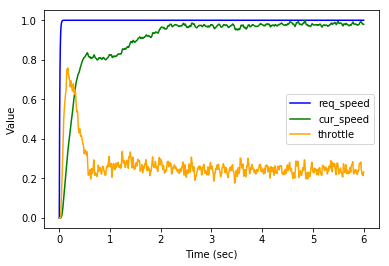

In [16]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_loihi_pid.trange(), sim_loihi_pid.data[pid.probe_req_speed], color = 'blue', label="req_speed")
plt.plot(sim_loihi_pid.trange(), sim_loihi_pid.data[pid.probe_cur_speed], color = 'green', label="cur_speed")
plt.plot(sim_loihi_pid.trange(), sim_loihi_pid.data[pid.probe_throttle], color = 'orange', label="throttle")
plt.legend()
plt.savefig('pid.jpg', dpi=350)

In [17]:
import nengo
import nengo_loihi
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
import os

nengo_loihi.set_defaults()
np.random.seed(42)
os.environ["SLURM"] = "1"

# Speed for normalization
max_speed = 5
speed = 1

tau_i = 0.1
Kp = -1
Ki = -0.1


class VehicleModel:
    def __init__(self):
        self.__throttle = 0.0
        self.__brake = 0.0
        self.__speed = 0.0

    # Throttle getter&setter
    def get_throttle(self):
        return self.__throttle

    def set_throttle(self, value):
        self.__throttle = np.clip(value, 0,1)

    # Brake getter&setter
    def get_brake(self):
        return self.__brake

    def set_brake(self, value):
        self.__brake = np.clip(value, 0, 1)

    # Speed getter
    def get_speed(self):
        return self.__speed

    # Speed setter
    def set_speed(self, value):
        self.__speed = value


car = VehicleModel()

def set_throttle_speed(t, x):
            val = x[0]
            if val >= 0:
                car.set_throttle(val)
                car.set_brake(0)
            else:
                car.set_throttle(0)
                car.set_brake(-val)

            s = car.get_speed()
            t = car.get_throttle()
            b = car.get_brake()

            # Use simple speed model
            s -= 0.005 # friction

            if t > 0.2: # throttle big enough to overcome friction
                s += t*0.025
            if b > 0:
                s -= b*0.05 # brakes are stronger than throttle
            s = np.clip(s, 0, 15) # clip max speed

            car.set_speed(s)
            s = s/max_speed

            return x[0],s

def feedback(x):
    return x
    


def PI_Controller():
    
    model = nengo.Network(seed=5)
    N = 500

    with model:   
        
        model.cur_speed = nengo.Node(size_in=1)
        model.throttle = nengo.Node(size_in=1)
        model.req_speed = nengo.Node(1)
        model.throttle_speed = nengo.Node(set_throttle_speed, size_in=1,size_out=2)
        
        nengo.Connection(model.throttle_speed[0],model.throttle)
        nengo.Connection(model.throttle_speed[1],model.cur_speed)
        
        model.vel_err = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=1.2, label='vel_err')
        model.int_ctrl = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=2, label='int_ctrl')
    
        model.err_sum = nengo.Ensemble(n_neurons=int(N*2), dimensions=1, radius=2, label='err_sum')
        
        
        # error = cur_speed - req_speed
        nengo.Connection(model.cur_speed, model.vel_err, transform=1)
        nengo.Connection(model.req_speed, model.vel_err, transform=-1)
                         
        
        # Proportional
        nengo.Connection(model.vel_err, model.err_sum, transform=Kp,
                            label='Kp')
        
        # Integral
        nengo.Connection(model.vel_err, model.int_ctrl, transform=tau_i)
        nengo.Connection(model.int_ctrl, model.int_ctrl, function=feedback, synapse=tau_i)
        nengo.Connection(model.int_ctrl, model.err_sum, transform=Ki)
        
       
        # Convert to throttle
        nengo.Connection(model.err_sum, model.throttle_speed, synapse=0.01)
        
        
        model.probe_vel_err = nengo.Probe(model.vel_err, synapse=0.05)

        model.probe_req_speed = nengo.Probe(model.req_speed, synapse=0.01)
        model.probe_cur_speed = nengo.Probe(model.cur_speed, synapse=0.01)
        model.probe_throttle = nengo.Probe(model.throttle, synapse=0.05)
    
        return model
    
        
model_PI = nengo.Network(label='PI Controller')
with model_PI:
    pi = PI_Controller()
    
    print('n_neurons: {}'.format(pi.n_neurons))



n_neurons: 3000


In [18]:
nengo_loihi.hardware.interface.HostSnip.recv_timeout = 1.0  # Default is 0.01 (10 ms)
nengo_loihi.hardware.interface.HostSnip.recv_retries = 100  # Default is 10

with nengo_loihi.Simulator(model_PI) as sim_loihi_pi:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi_pi.run(6)

/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 4 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:40617
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Compiling Host snips........Done 1.09s
INFO:DRV:      Encoding axons/synapses.....Done 0.78s
INFO:DRV:      Compiling Embedded snips....Done 0.38s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604665968.5283082/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Encoding probes.............Done 2.94ms
INFO:DRV:      Transferring spikes.........Done 1.30ms
INFO:DRV:      Configuring registers.......Done 0.11s
INFO:DRV:      Transferring probes.........Done 4.30ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

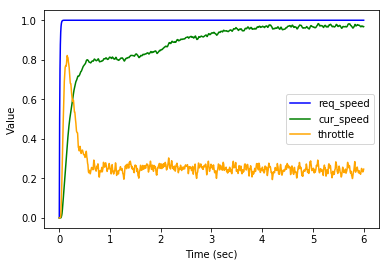

In [19]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_loihi_pi.trange(), sim_loihi_pi.data[pi.probe_req_speed], color = 'blue', label="req_speed")
plt.plot(sim_loihi_pi.trange(), sim_loihi_pi.data[pi.probe_cur_speed], color = 'green', label="cur_speed")
plt.plot(sim_loihi_pi.trange(), sim_loihi_pi.data[pi.probe_throttle], color = 'orange', label="throttle")
plt.legend()
plt.savefig('pi.jpg', dpi=350)

In [20]:
import nengo
import nengo_loihi
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
import os

nengo_loihi.set_defaults()
np.random.seed(42)
os.environ["SLURM"] = "1"

# Speed for normalization
max_speed = 5
speed = 1

Kp = -1


class VehicleModel:
    def __init__(self):
        self.__throttle = 0.0
        self.__brake = 0.0
        self.__speed = 0.0

    # Throttle getter&setter
    def get_throttle(self):
        return self.__throttle

    def set_throttle(self, value):
        self.__throttle = np.clip(value, 0,1)

    # Brake getter&setter
    def get_brake(self):
        return self.__brake

    def set_brake(self, value):
        self.__brake = np.clip(value, 0, 1)

    # Speed getter
    def get_speed(self):
        return self.__speed

    # Speed setter
    def set_speed(self, value):
        self.__speed = value


car = VehicleModel()

def set_throttle_speed(t, x):
            val = x[0]
            if val >= 0:
                car.set_throttle(val)
                car.set_brake(0)
            else:
                car.set_throttle(0)
                car.set_brake(-val)

            s = car.get_speed()
            t = car.get_throttle()
            b = car.get_brake()

            # Use simple speed model
            s -= 0.005 # friction

            if t > 0.2: # throttle big enough to overcome friction
                s += t*0.025
            if b > 0:
                s -= b*0.05 # brakes are stronger than throttle
            s = np.clip(s, 0, 15) # clip max speed

            car.set_speed(s)
            s = s/max_speed

            return x[0],s

def feedback(x):
    return x
    


def P_Controller():

    model = nengo.Network(seed=5)
    N = 500

    with model:   
        
        model.cur_speed = nengo.Node(size_in=1)
        model.throttle = nengo.Node(size_in=1)
        model.req_speed = nengo.Node(1)
        model.throttle_speed = nengo.Node(set_throttle_speed, size_in=1,size_out=2)
        
        nengo.Connection(model.throttle_speed[0],model.throttle)
        nengo.Connection(model.throttle_speed[1],model.cur_speed)
        
        model.vel_err = nengo.Ensemble(n_neurons=2*N, dimensions=1, radius=1.2, label='vel_err')
    
        model.err_sum = nengo.Ensemble(n_neurons=int(N*2), dimensions=1, radius=2, label='err_sum')
        
        
        # error = cur_speed - req_speed
        nengo.Connection(model.cur_speed, model.vel_err, transform=1)
        nengo.Connection(model.req_speed, model.vel_err, transform=-1)
                         
        
        # Proportional
        nengo.Connection(model.vel_err, model.err_sum, transform=Kp,
                            label='Kp')
        
        # Convert to throttle
        nengo.Connection(model.err_sum, model.throttle_speed, synapse=0.01)
        
        
        model.probe_vel_err = nengo.Probe(model.vel_err, synapse=0.05)

        model.probe_req_speed = nengo.Probe(model.req_speed, synapse=0.01)
        model.probe_cur_speed = nengo.Probe(model.cur_speed, synapse=0.01)
        model.probe_throttle = nengo.Probe(model.throttle, synapse=0.05)
    
        return model
   
    
model_P = nengo.Network(label='P Controller')
with model_P:
    p = P_Controller()
    
    print('n_neurons: {}'.format(p.n_neurons))



n_neurons: 2000


In [21]:
nengo_loihi.hardware.interface.HostSnip.recv_timeout = 1.0  # Default is 0.01 (10 ms)
nengo_loihi.hardware.interface.HostSnip.recv_retries = 100  # Default is 10

with nengo_loihi.Simulator(model_P) as sim_loihi_p:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi_p.run(6)

/homes/nbel/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:32809
INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Encoding axons/synapses.....Done 0.31s
INFO:DRV:      Compiling Host snips........Done 1.09s
INFO:DRV:      Compiling Embedded snips....Done 0.43s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604666010.2567203/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Encoding probes.............Done 0.81ms
INFO:DRV:      Configuring registers.......Done 0.06s
INFO:DRV:      Transferring spikes.........Done 1.28ms
INFO:DRV:      Transferring probes.........Done 4.12ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

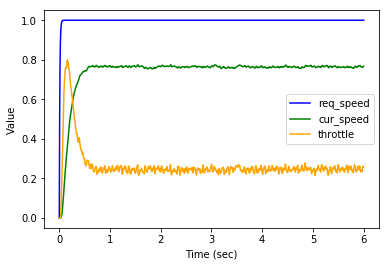

In [22]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_loihi_p.trange(), sim_loihi_p.data[p.probe_req_speed], color = 'blue', label="req_speed")
plt.plot(sim_loihi_p.trange(), sim_loihi_p.data[p.probe_cur_speed], color = 'green', label="cur_speed")
plt.plot(sim_loihi_p.trange(), sim_loihi_p.data[p.probe_throttle], color = 'orange', label="throttle")
plt.legend()
plt.savefig('p.jpg', dpi=350)

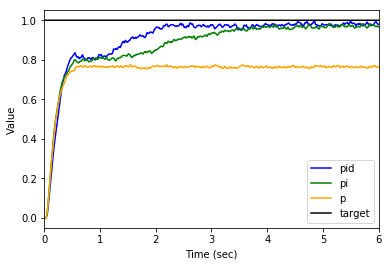

In [23]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_loihi_pid.trange(), sim_loihi_pid.data[pid.probe_cur_speed], color = 'blue', label="pid")
plt.plot(sim_loihi_pi.trange(), sim_loihi_pi.data[pi.probe_cur_speed], color = 'green', label="pi")
plt.plot(sim_loihi_p.trange(), sim_loihi_p.data[p.probe_cur_speed], color = 'orange', label="p")
plt.plot(sim_loihi_p.trange(), np.ones(len(sim_loihi_p.data[p.probe_cur_speed])), color = 'black', label="target")
plt.legend()
plt.xlim(0, 6)
plt.savefig('pid_pi_p.jpg', dpi=350)

In [24]:

with nengo.Simulator(model_PID) as sim_pid:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_pid.run(6)
with nengo.Simulator(model_PI) as sim_pi:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_pi.run(6)
with nengo.Simulator(model_P) as sim_p:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_p.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

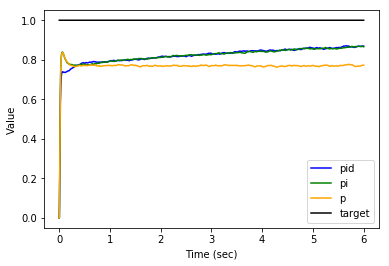

In [25]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_pid.trange(), sim_pid.data[pid.probe_cur_speed], color = 'blue', label="pid")
plt.plot(sim_pi.trange(), sim_pi.data[pi.probe_cur_speed], color = 'green', label="pi")
plt.plot(sim_p.trange(), sim_p.data[p.probe_cur_speed], color = 'orange', label="p")
plt.plot(sim_p.trange(), np.ones(len(sim_p.data[p.probe_cur_speed])), color = 'black', label="target")

plt.legend()
plt.savefig('pid_pi_p_sim.jpg', dpi=350)

In [26]:
data_dict =  {'t': sim_loihi_pid.trange(),
              'sim_p' : sim_p.data[p.probe_cur_speed],
              'sim_pi' : sim_pi.data[pi.probe_cur_speed],
              'sim_pid' : sim_pid.data[pid.probe_cur_speed],
              'loihi_p' : sim_loihi_p.data[p.probe_cur_speed],
              'loihi_pi' : sim_loihi_pi.data[pi.probe_cur_speed],
              'loihi_pid' : sim_loihi_pid.data[pid.probe_cur_speed],
}

import pickle
with open('info.pkl','wb') as f:
    pickle.dump(data_dict, f)